In [4]:
#!/usr/bin/env python
"""
--------------------------------------------------------------------------
Created June 20, 2023 for TRIPs-Py library
"""
__author__ = "Mirjeta Pasha and Connor Sanderford"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = "Mirjeta Pasha and Connor Sanderford"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and "
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
from trips.operators import *
##Specify the font
##Latex needs to be installed! If not installed, please comment the following 5 lines
parameters = {'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'axes.titlesize': 18, 'axes.labelsize': 18, 'figure.titlesize': 14, 'legend.fontsize': 13}
plt.rcParams.update(parameters)
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
# import phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
from trips.testProblems import *
from trips.solvers.gks import *
import requests
from scipy import sparse
import numpy as np
import h5py
# functions to generate emoji data are stored in io_l.py
from trips.io import *
from trips.operators import *
from trips.solvers.AnisoTV import *
from trips.helpers import *

# Notebook 1: Emoji test problem

<p>In this example we illustrate the following:
<p>&nbsp; Step 1: Download/read the emoji data and prepare them for processing.
<p>&nbsp; Step 2: Solve the static inverse problem.
<p>&nbsp; Step 3: Solve the dynamic inverse problem.

Emoji data are generated at the University of Helsinki: https://zenodo.org/record/1183532#.YyaW_C9h2fU


#### Step 1: Download/read the data and prepare them for processing
##### The main function to generate the emoji data is generate_emoji(dataset, noise_level) 
<p> <b>Input:</b> 
<p>&nbsp; <b>dataset:</b>
        <p>&nbsp; if dataset = 30, we generate data from DataDynamic_128x30.mat
        <p>&nbsp; if dataset = 60, we generate data from DataDynamic_128x60.mat
<p>&nbsp; <b>noise_level:</b>
        <p>&nbsp; Emoji data are real data and they have noise. Hence, we set noise_level = 0
            
<p> <b>Output:</b>  
&nbsp;<br> <b>A:</b> The full forward operator for all time instances<br>
&nbsp; <b>b:</b> All the data/measurements vectorized<br> 
&nbsp; <b>AA:</b> A list of 33 time-wise operators<br> 
&nbsp; <b>B:</b> A list of 33 data vectors for each time instance <br> 
&nbsp; <b>nx:</b> The dimension of the first spatial domain<br> 
&nbsp; <b>ny:</b> The dimension of the second spatial domain<br> 
&nbsp; <b>nt:</b> The dimension of the time instances domain<br> 
&nbsp; <b>delta:</b> The noise level in the data. When we set noise_level == 0, we get delta = 0<br> 
&nbsp; <b>sinoshape:</b> The dimension of the time-wise sinogram<br>     

In [5]:
(A, b, AA, B, nx, ny, nt, delta) = generate_emoji(noise_level = 0.01, dataset = 30)

data already downloaded.


#### Step 2: Solve the static inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [5]:
xx = list(range(nt))
L = spatial_derivative_operator(nx, ny, 1)
for i in range(nt):
    b_vec = B[i].reshape((-1,1))
    (x, x_history, lambdah, lambda_history) = GKS(AA[i], b_vec, L, pnorm=2, qnorm=1, projection_dim=3, n_iter = 2, regparam='gcv', x_true=None)
    xx[i] = x

generating basis...:   0%|          | 0/3 [00:00<?, ?it/s]

running GKS...:  16%|█▌        | 8/50 [00:18<02:00,  2.88s/it]

running GKS...:  18%|█▊        | 9/50 [00:22<02:08,  3.13s/it]

#### Step 3: Solve dynamic inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [6]:
regvals = [0.1*(0.5**(x)) for x in range(0,80)]

In [25]:
b_vec = b.reshape((-1,1))
# L = spatial_derivative_operator(nx, ny, nt)
L = time_derivative_operator(nx, ny, nt)
(xx, x_history, lambdah, lambda_history) = GKS(A, b, L, projection_dim = 1, n_iter = 3, regparam = 'gcv', x_true = None)

running GKS...: 100%|██████████| 3/3 [00:10<00:00,  3.39s/it]


<Figure size 432x288 with 0 Axes>

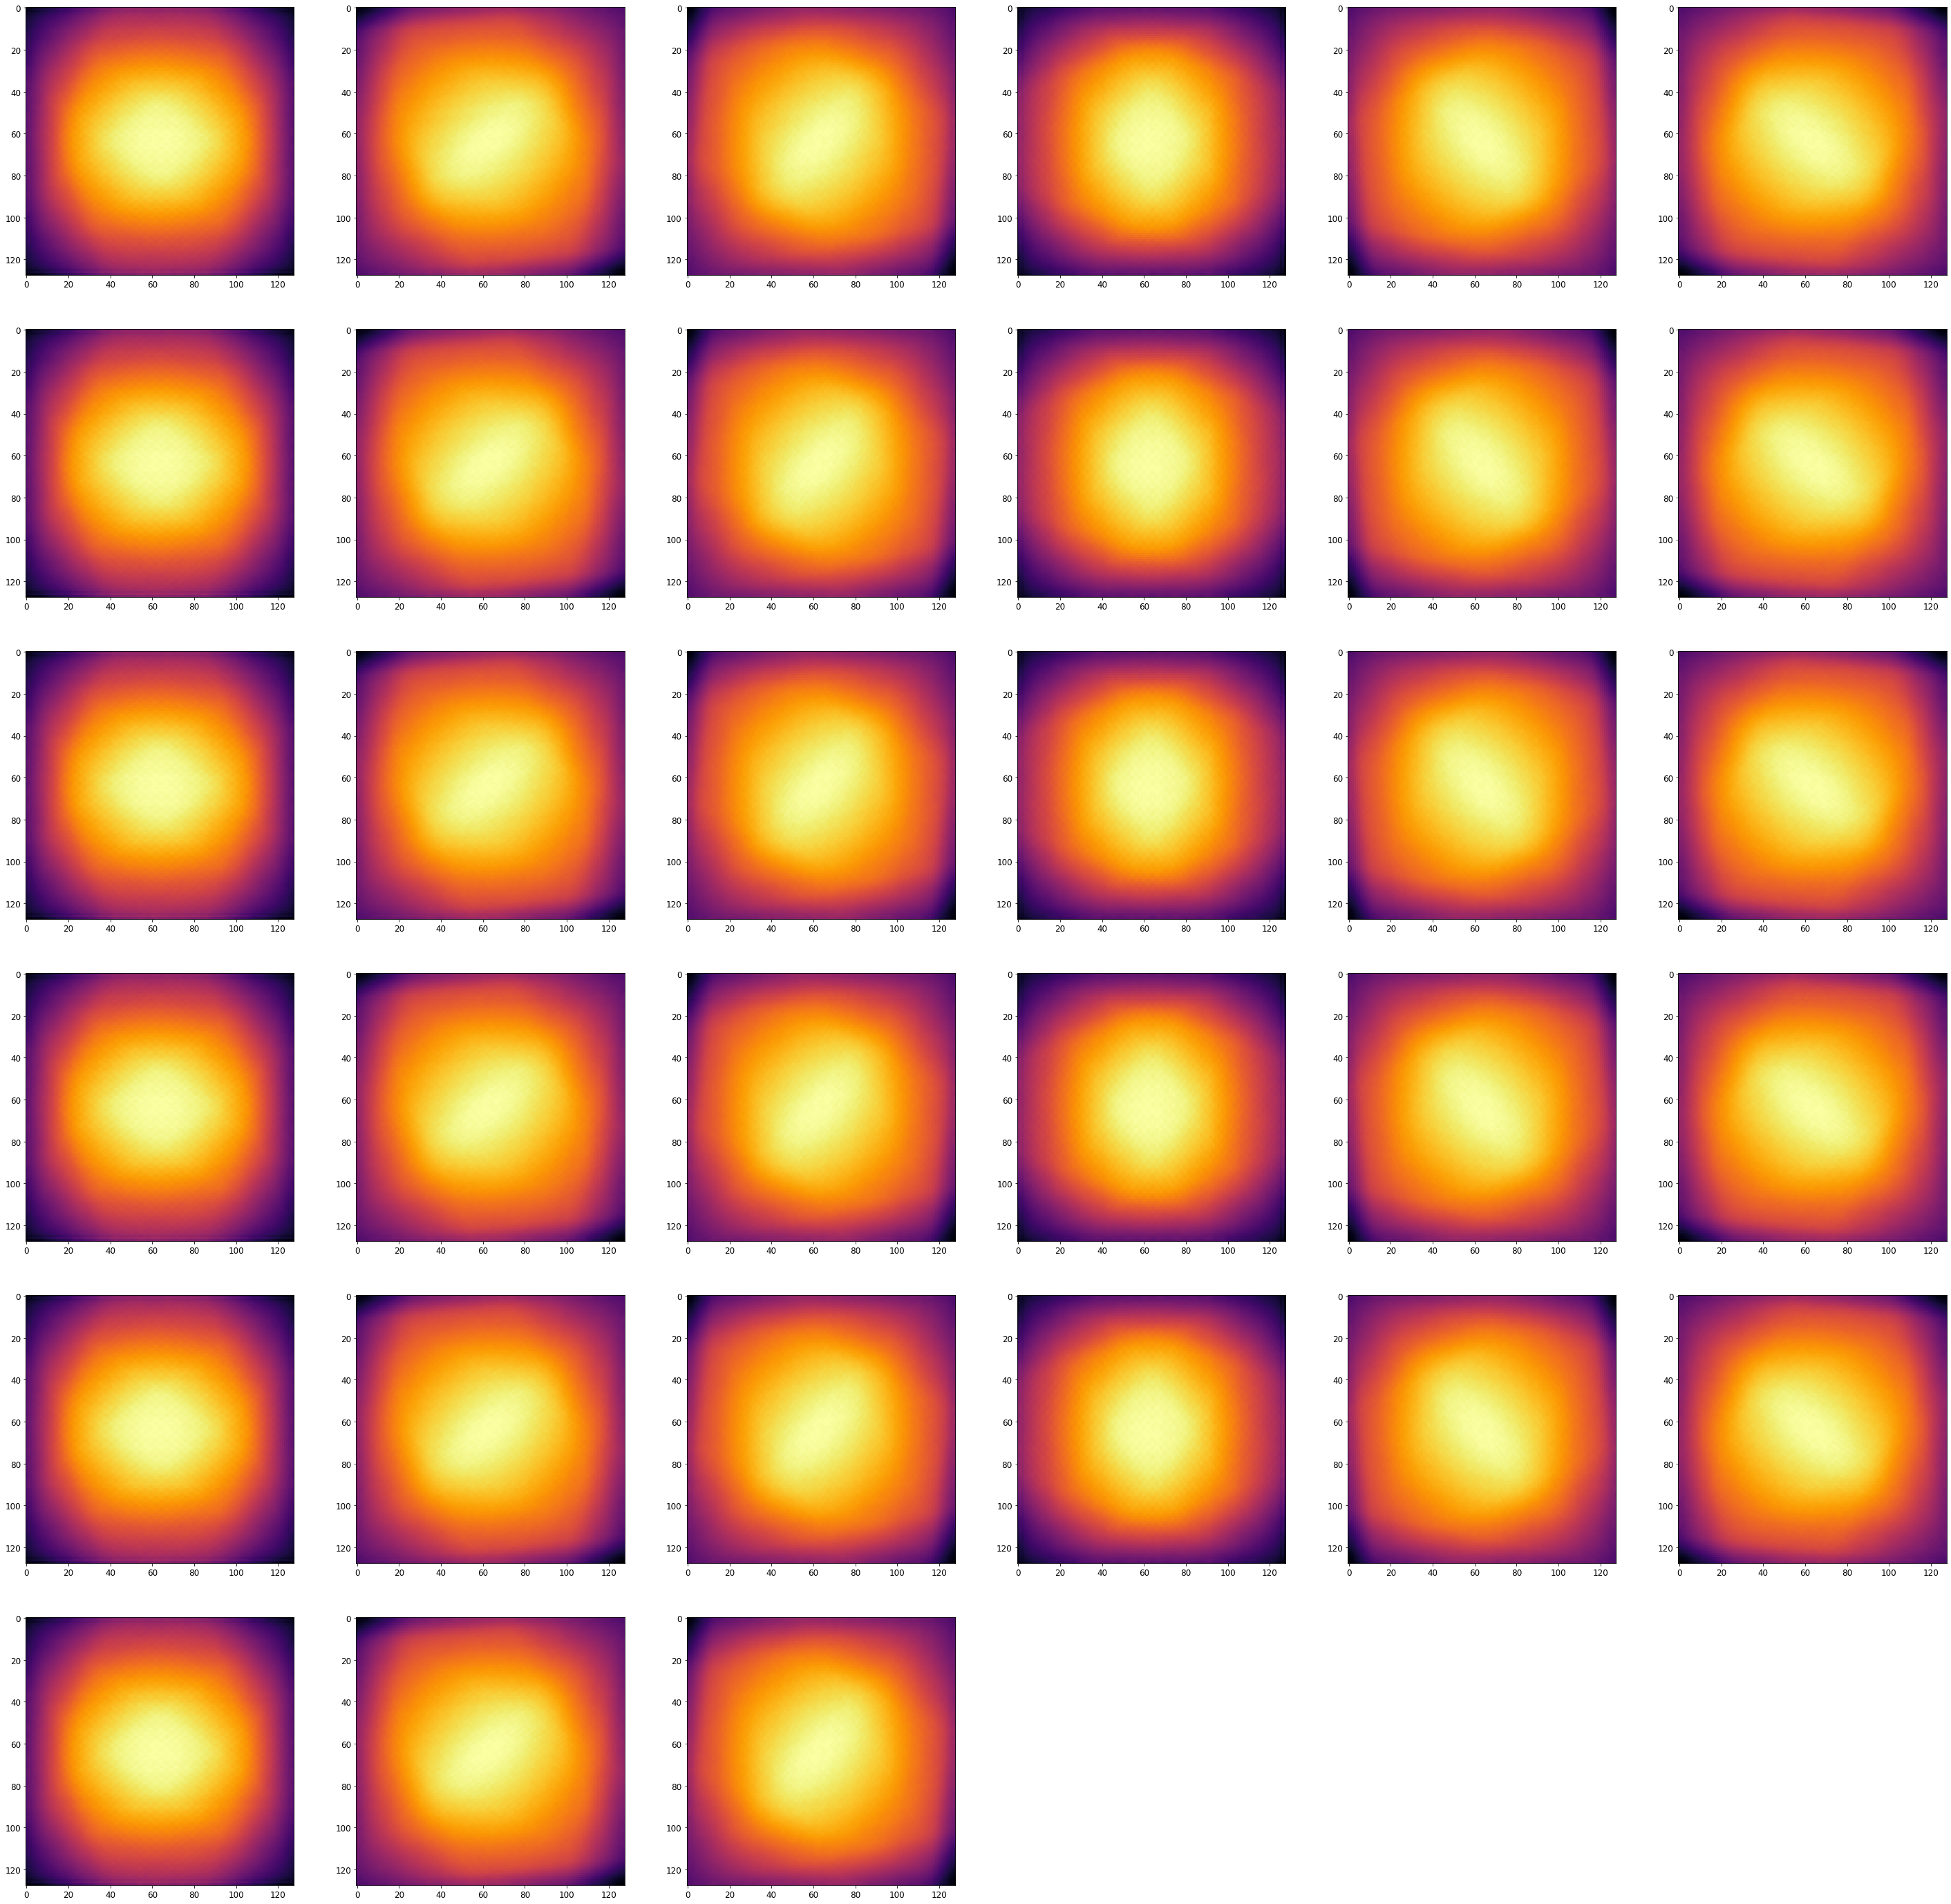

In [26]:
plot_recstructions_series(x, (nx, ny, nt), dynamic = True, testproblem = 'Emoji', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/Emoji')

#### Step 4: Solve the i-th static problem by Golub-Kahan

In [12]:
from trips.decompositions import *
(U, Beta, V) = lanczos_biortho_pasha(AA[1], B[1], iter = 3)

In [13]:
(U, Bigiag, V) = generalized_golub_kahan(AA[10], B[10], n_iter = 4, dp_stop=False)

generating basis...: 100%|██████████| 4/4 [00:00<00:00, 67.18it/s]


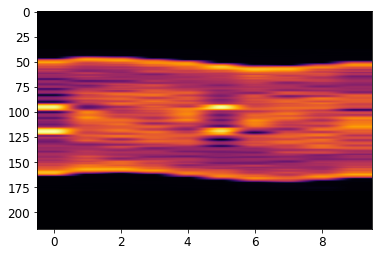

In [14]:
import matplotlib.pyplot as plt
plt.imshow(B[1].reshape(217, 10, order='F'), aspect = 'auto')

In [15]:
i = 1
b_vec = B[i].reshape((-1,1))
projection_dim = 5
(U, Bigiag, V) = generalized_golub_kahan(AA[i], b_vec, projection_dim)
VV = V
UU = U[:, 0:-1]
HH = Bigiag[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_GKahan = VV.dot(y_tikh)

generating basis...: 100%|██████████| 5/5 [00:00<00:00, 259.01it/s]


#### Step 5: Solve the dynamic problem by Golub-Kahan

In [16]:
b_vec = b.reshape((-1,1))
projection_dim = 5
(U, Bidiag, V) = generalized_golub_kahan(A, b_vec, projection_dim)
VV = V
UU = U[:, 0:-1]
HH = Bidiag[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_GKahan = VV.dot(y_tikh)

generating basis...: 100%|██████████| 5/5 [00:00<00:00, 10.14it/s]


<Figure size 432x288 with 0 Axes>

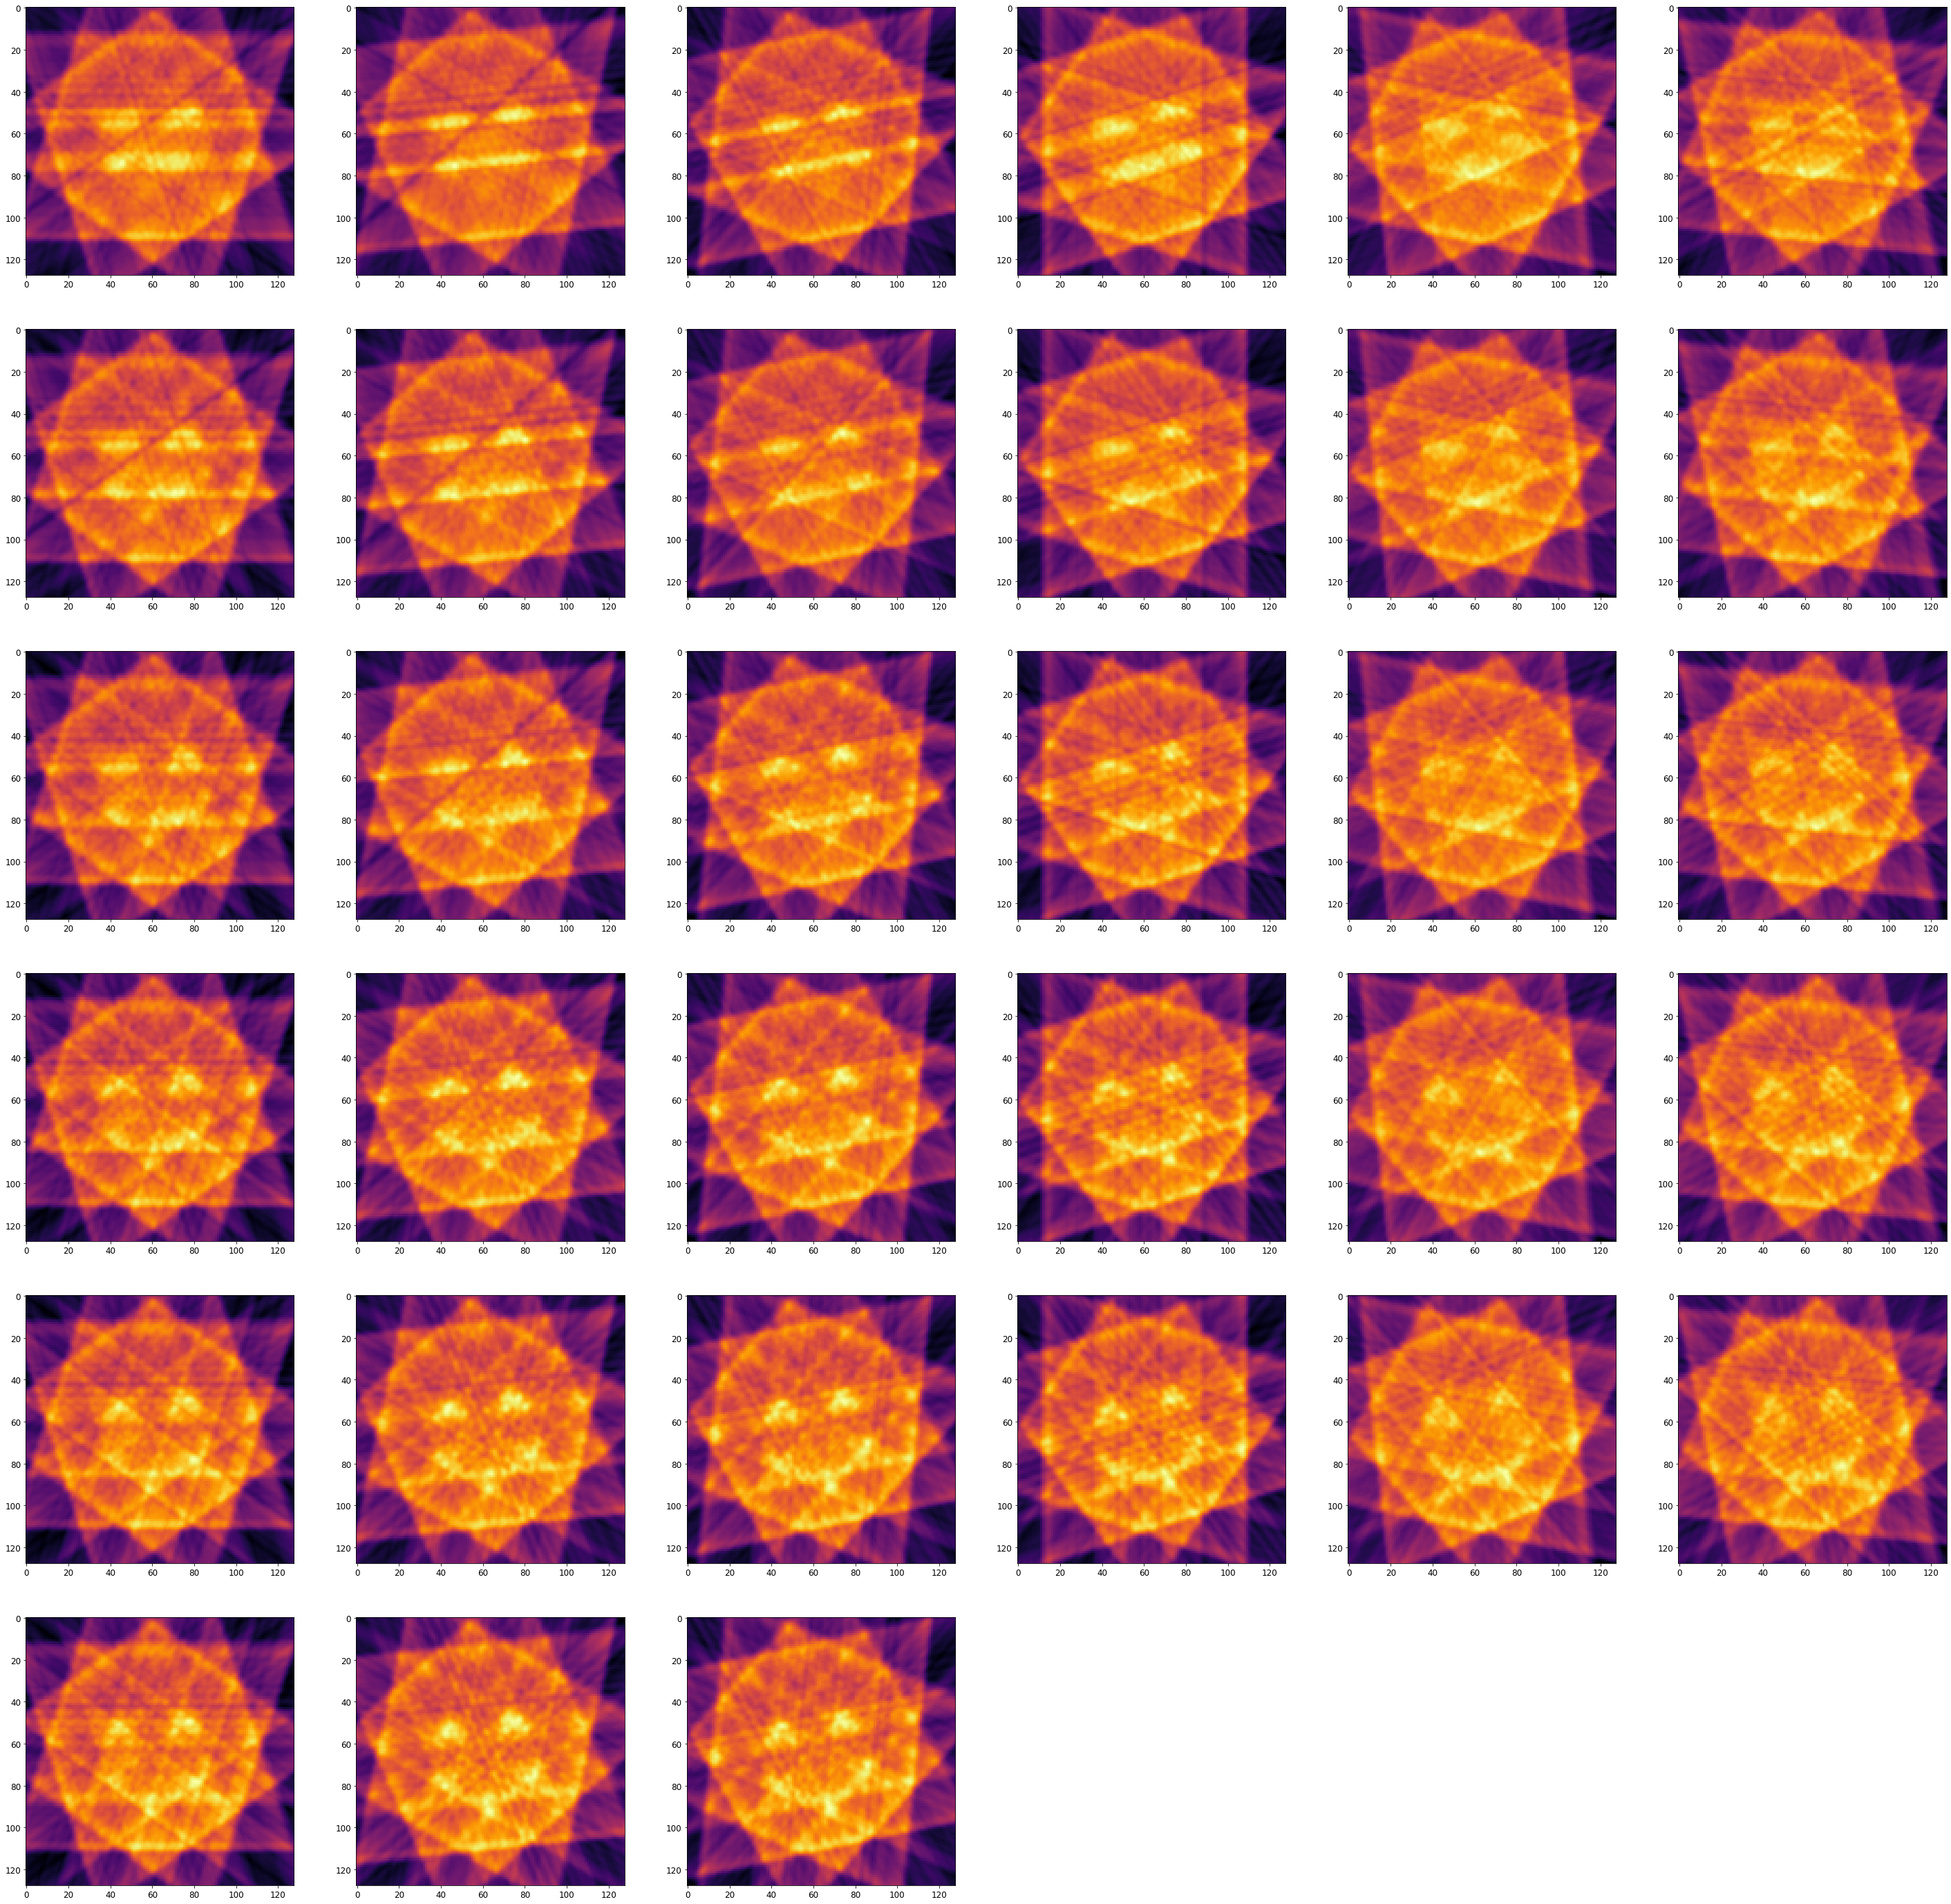

In [17]:
plot_recstructions_series(x_GKahan, (nx, ny, nt), dynamic = True, testproblem = 'emoji', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/emoji')